In [1]:
import pandas as pd
from sodapy import Socrata


client = Socrata("data.cdc.gov",None)
results = client.get("r8kw-7aab",limit=2000)


In [2]:
float_cols=['total_deaths', 'percent_of_expected_deaths', 'pneumonia_deaths','pneumonia_and_covid_deaths', 'influenza_deaths', 'pneumonia_influenza_and_covid']
date_cols=['data_as_of','start_week','end_week']
def transform_df(df,date_cols,float_cols):
    for col in date_cols:
        df[col] = pd.to_datetime(df[col])
    for col in float_cols:
        df[col] = df[col].astype(float)
    return df.drop_duplicates(subset=['start_week','state','indicator'],keep='last').reset_index(drop=True)

results_df = pd.DataFrame.from_records(results).pipe(transform_df,date_cols,float_cols)

results_df.head()

,data_as_of,start_week,end_week,group,state,indicator,covid_deaths,total_deaths,percent_of_expected_deaths,pneumonia_deaths,pneumonia_and_covid_deaths,influenza_deaths,pneumonia_influenza_and_covid,footnote
0,2020-05-08,2020-02-01,2020-02-01,By week,United States,Week-ending,0,57444.0,0.97,3700.0,0.0,471.0,4171.0,NaN
1,2020-05-08,2020-02-08,2020-02-08,By week,United States,Week-ending,1,57766.0,0.97,3686.0,0.0,499.0,4186.0,NaN
2,2020-05-08,2020-02-15,2020-02-15,By week,United States,Week-ending,0,57077.0,0.97,3710.0,0.0,521.0,4231.0,NaN
3,2020-05-08,2020-02-22,2020-02-22,By week,United States,Week-ending,1,57041.0,0.98,3573.0,0.0,541.0,4115.0,NaN
4,2020-05-08,2020-02-29,2020-02-29,By week,United States,Week-ending,7,57252.0,0.99,3663.0,5.0,623.0,4288.0,NaN


In [3]:
results_df.start_week.unique()

array(['2020-02-01T00:00:00.000000000', '2020-02-08T00:00:00.000000000',
       '2020-02-15T00:00:00.000000000', '2020-02-22T00:00:00.000000000',
       '2020-02-29T00:00:00.000000000', '2020-03-07T00:00:00.000000000',
       '2020-03-14T00:00:00.000000000', '2020-03-21T00:00:00.000000000',
       '2020-03-28T00:00:00.000000000', '2020-04-04T00:00:00.000000000',
       '2020-04-11T00:00:00.000000000', '2020-04-18T00:00:00.000000000',
       '2020-04-25T00:00:00.000000000', '2020-05-02T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [4]:
results_df['state'].unique()

array(['United States', 'Alabama', 'Alaska', 'Maryland', 'Arizona',
       'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware',
       'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'New York', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
       'Louisiana', 'Maine', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York City',
       'North Carolina', 'North Dakota', 'Oklahoma', 'Ohio', 'Oregon',
       'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming', 'Puerto Rico'],
      dtype=object)

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff6f196c810>)

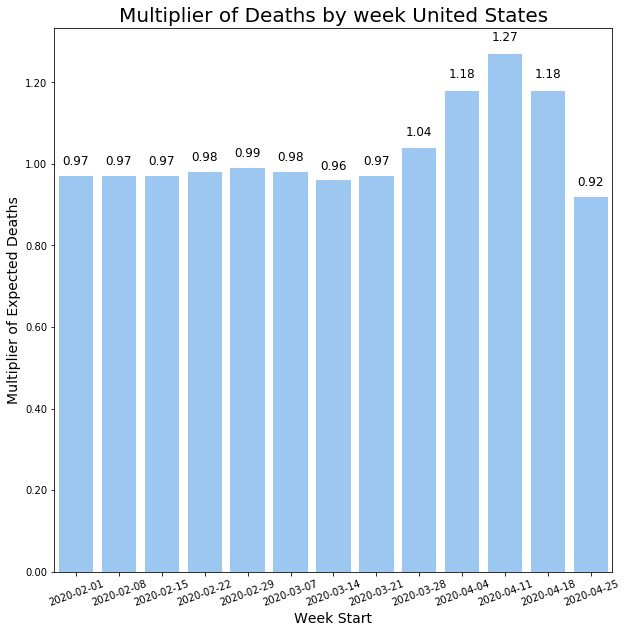

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import DateFormatter
%matplotlib inline

def autolabel(rects, ax, loc = 1.02, perc = True, ha = 'center'):
    # attach some text labels

    for rect in rects:
        height = rect.get_height()
        if perc:
            bar_label = '%1.1f' % float(height*100) + "%"
        else:
            bar_label = '%1.2f' % float(height)
        ax.text(rect.get_x() + rect.get_width()/2., loc*height,
                bar_label,
                ha=ha, va='bottom', fontsize = 12)

def plot_death_bar(df,state='United States',with_multiplier='percent'):
    data = df[df['state']==state]
    fig,ax = plt.subplots(figsize=(10,10))
    if with_multiplier=='percent':
        formatter = FuncFormatter(lambda y, pos:"%d%%" % (y*100))
    else:
        formatter = FuncFormatter(lambda y, pos:"%.2f" % (y))
#     data['percent_of_expected_deaths']-=1
    sns.barplot(x='start_week',y='percent_of_expected_deaths',data=data,color='dodgerblue',alpha=.5)
#     ax.set_xticks(data['start_week'])
    percent = (with_multiplier=='percent')
    autolabel(ax.patches,ax,perc=percent)
    ax.xaxis.set_tick_params(rotation=20)
    ax.yaxis.set_major_formatter(formatter)
    ax.set_xticklabels(data['start_week'].dt.strftime('%Y-%m-%d'))
    if with_multiplier=='percent':
        ax.set_title('Percent of Deaths by week {}'.format(state),fontsize=20)
        ax.set_ylabel('Percent of Expected Deaths',fontsize=14)
    else:
        ax.set_title('Multiplier of Deaths by week {}'.format(state),fontsize=20)
        ax.set_ylabel('Multiplier of Expected Deaths',fontsize=14)
    ax.set_xlabel("Week Start",fontsize=14)
    return fig,ax

def plot_death_line(df,state_list=[]):
    state_list = ['United States']+state_list
    data = df[df['state'].isin(state_list)]
    fig,ax = plt.subplots(figsize=(10,10))
    formatter = FuncFormatter(lambda y, pos:"%d%%" % (y*100))
    sns.lineplot(x='start_week',y='percent_of_expected_deaths',data=data,hue='state')
#     ax.set_xticks(data['start_week'])
#     autolabel(ax.patches,ax)
    ax.xaxis.set_tick_params(rotation=20)
    ax.yaxis.set_major_formatter(formatter)
    ax.set_xticks(data['start_week'].drop_duplicates())
#     ax.set_xticklabels(data['start_week'].drop_duplicates().dt.strftime('%Y-%m-%d').iloc[::2])
#     ax.set_xticklabels(data['start_week'].dt.strftime('%Y-%m-%d'))
    ax.set_title('Percent of Deaths by week US',fontsize=20)
    ax.set_ylabel('Percent of Expected Deaths',fontsize=14)
    ax.set_xlabel("Week Start",fontsize=14)
    return fig,ax

plot_death_bar(results_df[results_df['start_week']<'2020-05-01'],with_multiplier='blue')

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff7c58b4090>)

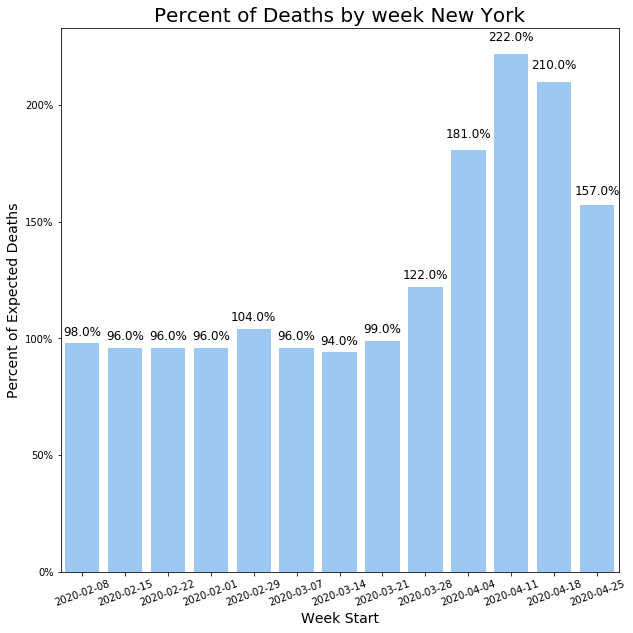

In [6]:
plot_death_bar(results_df[results_df['start_week']<'2020-05-01'],'New York')

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff7c5a12950>)

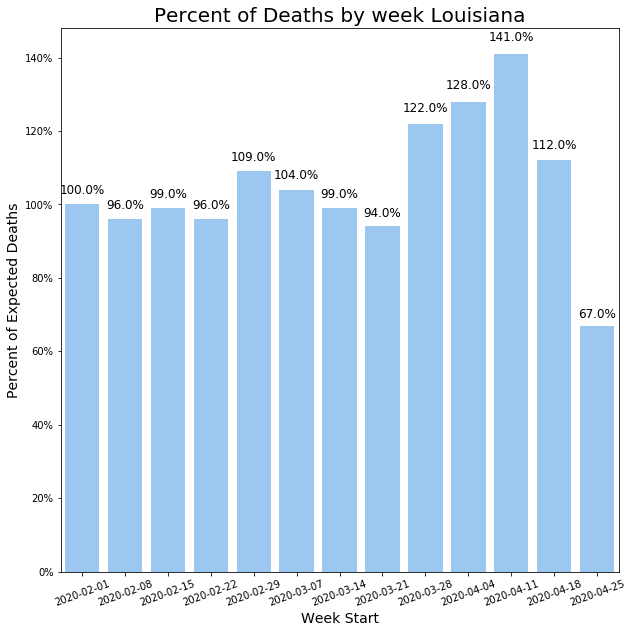

In [7]:
plot_death_bar(results_df[results_df['start_week']<'2020-05-01'],'Louisiana')

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff7c595bc10>)

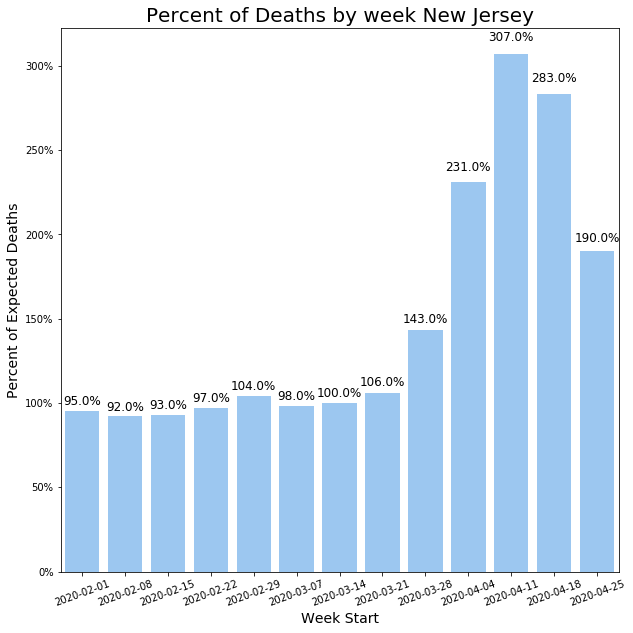

In [8]:
plot_death_bar(results_df[results_df['start_week']<'2020-05-01'],'New Jersey')

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff6f1951090>)

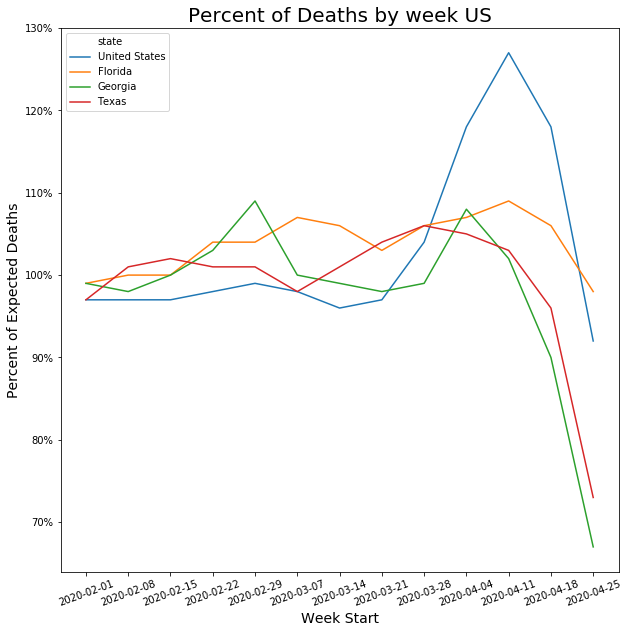

In [134]:
plot_death_line(results_df[results_df['start_week']<'2020-05-01'],['Florida','Georgia','Texas'])

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff7c5586290>)

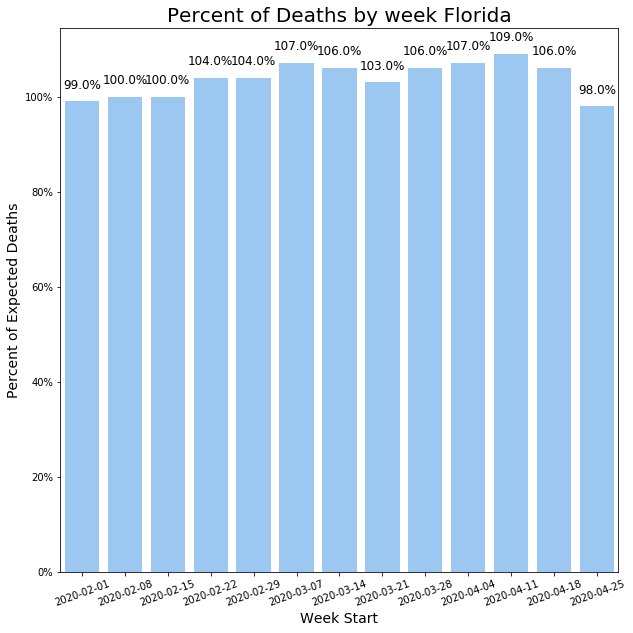

In [10]:
plot_death_bar(results_df[results_df['start_week']<'2020-05-01'],'Florida')

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff7c44c6bd0>)

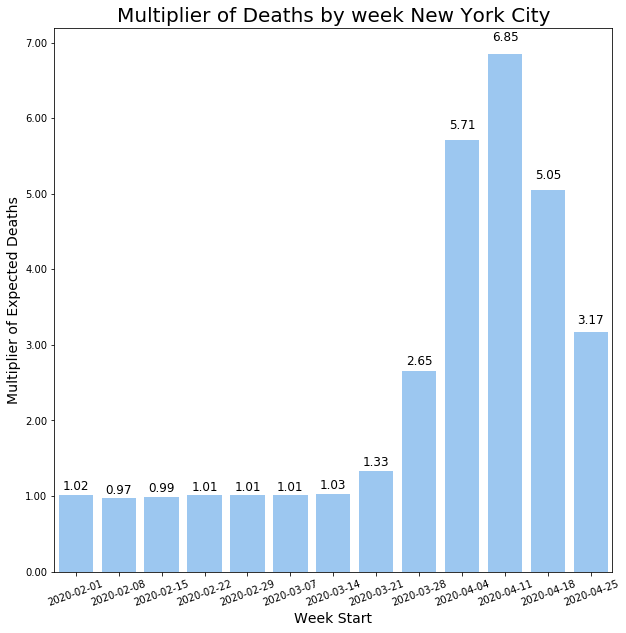

In [11]:
plot_death_bar(results_df[results_df['start_week']<'2020-05-01'],'New York City',with_multiplier='yes')

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff7c441a110>)

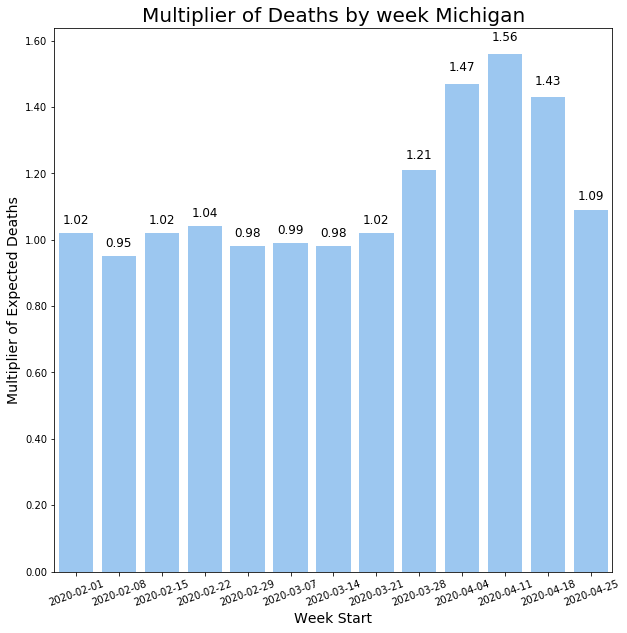

In [12]:
plot_death_bar(results_df[results_df['start_week']<'2020-05-01'],'Michigan',with_multiplier='yes')

In [13]:
results_df.sort_values(by='percent_of_expected_deaths',ascending=False).head(20)

,data_as_of,start_week,end_week,group,state,indicator,covid_deaths,total_deaths,percent_of_expected_deaths,pneumonia_deaths,pneumonia_and_covid_deaths,influenza_deaths,pneumonia_influenza_and_covid,footnote
486,2020-05-08,2020-04-11,2020-04-11,By week,New York City,Week-ending,4175,7302.0,6.85,1929.0,1523.0,320.0,4591.0,NaN
485,2020-05-08,2020-04-04,2020-04-04,By week,New York City,Week-ending,2828,5878.0,5.71,1649.0,1183.0,208.0,3303.0,NaN
487,2020-05-08,2020-04-18,2020-04-18,By week,New York City,Week-ending,3172,5134.0,5.05,1265.0,1089.0,162.0,3351.0,NaN
488,2020-05-08,2020-04-25,2020-04-25,By week,New York City,Week-ending,1797,3126.0,3.17,791.0,666.0,72.0,1926.0,NaN
447,2020-05-08,2020-04-11,2020-04-11,By week,New Jersey,Week-ending,1867,4369.0,3.07,1274.0,955.0,NaN,2189.0,One or more data cells have counts between 1–9...
448,2020-05-08,2020-04-18,2020-04-18,By week,New Jersey,Week-ending,1790,4019.0,2.83,1093.0,837.0,NaN,2048.0,One or more data cells have counts between 1–9...
484,2020-05-08,2020-03-28,2020-03-28,By week,New York City,Week-ending,875,2725.0,2.65,584.0,332.0,45.0,1134.0,NaN
446,2020-05-08,2020-04-04,2020-04-04,By week,New Jersey,Week-ending,1064,3386.0,2.31,850.0,551.0,NaN,1371.0,One or more data cells have counts between 1–9...
472,2020-05-08,2020-04-11,2020-04-11,By week,New York,Week-ending,1723,4376.0,2.22,1227.0,893.0,11.0,2064.0,NaN
473,2020-05-08,2020-04-18,2020-04-18,By week,New York,Week-ending,1647,4056.0,2.10,1095.0,816.0,NaN,1929.0,One or more data cells have counts between 1–9...


In [14]:
(results_df['start_week']<'2020-05-01').sum()

702

In [15]:
results_df[results_df['state'].isin(['United States'])]

,data_as_of,start_week,end_week,group,state,indicator,covid_deaths,total_deaths,percent_of_expected_deaths,pneumonia_deaths,pneumonia_and_covid_deaths,influenza_deaths,pneumonia_influenza_and_covid,footnote
0,2020-05-08,2020-02-01,2020-02-01,By week,United States,Week-ending,0,57444.0,0.97,3700.0,0.0,471.0,4171.0,NaN
1,2020-05-08,2020-02-08,2020-02-08,By week,United States,Week-ending,1,57766.0,0.97,3686.0,0.0,499.0,4186.0,NaN
2,2020-05-08,2020-02-15,2020-02-15,By week,United States,Week-ending,0,57077.0,0.97,3710.0,0.0,521.0,4231.0,NaN
3,2020-05-08,2020-02-22,2020-02-22,By week,United States,Week-ending,1,57041.0,0.98,3573.0,0.0,541.0,4115.0,NaN
4,2020-05-08,2020-02-29,2020-02-29,By week,United States,Week-ending,7,57252.0,0.99,3663.0,5.0,623.0,4288.0,NaN
5,2020-05-08,2020-03-07,2020-03-07,By week,United States,Week-ending,29,56850.0,0.98,3766.0,16.0,594.0,4372.0,NaN
6,2020-05-08,2020-03-14,2020-03-14,By week,United States,Week-ending,50,54895.0,0.96,3726.0,25.0,590.0,4340.0,NaN
7,2020-05-08,2020-03-21,2020-03-21,By week,United States,Week-ending,504,54997.0,0.97,4229.0,230.0,504.0,5001.0,NaN
8,2020-05-08,2020-03-28,2020-03-28,By week,United States,Week-ending,2771,58379.0,1.04,5722.0,1265.0,416.0,7596.0,NaN
9,2020-05-08,2020-04-04,2020-04-04,By week,United States,Week-ending,8437,65937.0,1.18,8994.0,4040.0,441.0,13614.0,NaN


In [16]:
results_df['data_as_of'].value_counts()

2020-05-08    756
Name: data_as_of, dtype: int64

In [17]:
county_data = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')

In [18]:
county_data.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


In [19]:
import geopandas as gpd

geo_df = gpd.read_file('./shape_files/cb_2018_us_county_500k.shp')

In [20]:
geo_df['fips'] = geo_df['GEOID'].astype(float)

In [21]:
final_geo_df = county_data.merge(geo_df,how='left',on='fips')

In [22]:
geo_df['GEOID'].astype(float)

0       21007.0
1       21017.0
2       21031.0
3       21065.0
4       21069.0
         ...   
3228    31073.0
3229    39075.0
3230    48171.0
3231    55079.0
3232    26139.0
Name: GEOID, Length: 3233, dtype: float64

In [23]:
final_geo_df

,date,county,state,fips,cases,deaths,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,2020-01-21,Snohomish,Washington,53061.0,1,0,53,061,01529222,0500000US53061,53061,Snohomish,06,5.404059e+09,2.829123e+08,"MULTIPOLYGON (((-122.33164 48.02056, -122.3283..."
1,2020-01-22,Snohomish,Washington,53061.0,1,0,53,061,01529222,0500000US53061,53061,Snohomish,06,5.404059e+09,2.829123e+08,"MULTIPOLYGON (((-122.33164 48.02056, -122.3283..."
2,2020-01-23,Snohomish,Washington,53061.0,1,0,53,061,01529222,0500000US53061,53061,Snohomish,06,5.404059e+09,2.829123e+08,"MULTIPOLYGON (((-122.33164 48.02056, -122.3283..."
3,2020-01-24,Cook,Illinois,17031.0,1,0,17,031,01784766,0500000US17031,17031,Cook,06,2.447371e+09,1.786313e+09,"POLYGON ((-88.26364 42.06687, -88.25835 42.066..."
4,2020-01-24,Snohomish,Washington,53061.0,1,0,53,061,01529222,0500000US53061,53061,Snohomish,06,5.404059e+09,2.829123e+08,"MULTIPOLYGON (((-122.33164 48.02056, -122.3283..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123944,2020-05-07,Sublette,Wyoming,56035.0,3,0,56,035,01605082,0500000US56035,56035,Sublette,06,1.265593e+10,1.273536e+08,"POLYGON ((-110.62343 42.77920, -110.58766 42.7..."
123945,2020-05-07,Sweetwater,Wyoming,56037.0,19,0,56,037,01609192,0500000US56037,56037,Sweetwater,06,2.700575e+10,1.662303e+08,"POLYGON ((-110.05438 42.01103, -110.05436 42.0..."
123946,2020-05-07,Teton,Wyoming,56039.0,98,1,56,039,01605083,0500000US56039,56039,Teton,06,1.035178e+10,5.708649e+08,"POLYGON ((-111.05361 44.66627, -110.75076 44.6..."
123947,2020-05-07,Uinta,Wyoming,56041.0,8,0,56,041,01605084,0500000US56041,56041,Uinta,06,5.391632e+09,1.662582e+07,"POLYGON ((-111.04662 41.15604, -111.04659 41.2..."


In [24]:
final_geo_df = final_geo_df[~final_geo_df['state'].isin(['Hawaii','Alaska','Puerto Rico'])].reset_index(drop=True)

In [25]:
day_list = final_geo_df['date'].unique().tolist()[11:]
day_list

['2020-02-01',
 '2020-02-02',
 '2020-02-03',
 '2020-02-04',
 '2020-02-05',
 '2020-02-06',
 '2020-02-07',
 '2020-02-08',
 '2020-02-09',
 '2020-02-10',
 '2020-02-11',
 '2020-02-12',
 '2020-02-13',
 '2020-02-14',
 '2020-02-15',
 '2020-02-16',
 '2020-02-17',
 '2020-02-18',
 '2020-02-19',
 '2020-02-20',
 '2020-02-21',
 '2020-02-22',
 '2020-02-23',
 '2020-02-24',
 '2020-02-25',
 '2020-02-26',
 '2020-02-27',
 '2020-02-28',
 '2020-02-29',
 '2020-03-01',
 '2020-03-02',
 '2020-03-03',
 '2020-03-04',
 '2020-03-05',
 '2020-03-06',
 '2020-03-07',
 '2020-03-08',
 '2020-03-09',
 '2020-03-10',
 '2020-03-11',
 '2020-03-12',
 '2020-03-13',
 '2020-03-14',
 '2020-03-15',
 '2020-03-16',
 '2020-03-17',
 '2020-03-18',
 '2020-03-19',
 '2020-03-20',
 '2020-03-21',
 '2020-03-22',
 '2020-03-23',
 '2020-03-24',
 '2020-03-25',
 '2020-03-26',
 '2020-03-27',
 '2020-03-28',
 '2020-03-29',
 '2020-03-30',
 '2020-03-31',
 '2020-04-01',
 '2020-04-02',
 '2020-04-03',
 '2020-04-04',
 '2020-04-05',
 '2020-04-06',
 '2020-04-

In [84]:
import mapclassify
import numpy as np

scheme = mapclassify.NaturalBreaks(final_geo_df['cases'],k=5)
scheme


NaturalBreaks                

      Interval          Count
-----------------------------
[    1.00,   944.00] | 117685
(  944.00,  3843.00] |   2895
( 3843.00,  9699.00] |    785
( 9699.00, 21828.00] |    306
(21828.00, 48341.00] |     99

In [71]:
final_geo_df.isna().sum()

date        0
county      0
state       0
fips        0
cases       0
deaths      0
STATEFP     0
COUNTYFP    0
COUNTYNS    0
AFFGEOID    0
GEOID       0
NAME        0
LSAD        0
ALAND       0
AWATER      0
geometry    0
dtype: int64

In [64]:
final_geo_df.dropna(inplace=True)


In [85]:
day_list[::5]

['2020-02-01',
 '2020-02-06',
 '2020-02-11',
 '2020-02-16',
 '2020-02-21',
 '2020-02-26',
 '2020-03-02',
 '2020-03-07',
 '2020-03-12',
 '2020-03-17',
 '2020-03-22',
 '2020-03-27',
 '2020-04-01',
 '2020-04-06',
 '2020-04-11',
 '2020-04-16',
 '2020-04-21',
 '2020-04-26',
 '2020-05-01',
 '2020-05-06']

/home/jaalhashash/miniconda/envs/jawsem_env/lib/python3.7/site-packages/geoplot/geoplot.py:1743: FutureWarning: The "contextily.tile_providers" module is deprecated and will be removed in contextily v1.1. Please use "contextily.providers" instead.
  url=getattr(ctx.sources, provider), ll=True
/home/jaalhashash/miniconda/envs/jawsem_env/lib/python3.7/site-packages/geoplot/geoplot.py:1743: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  url=getattr(ctx.sources, provider), ll=True


2020-05-05
2020-05-06
2020-05-07


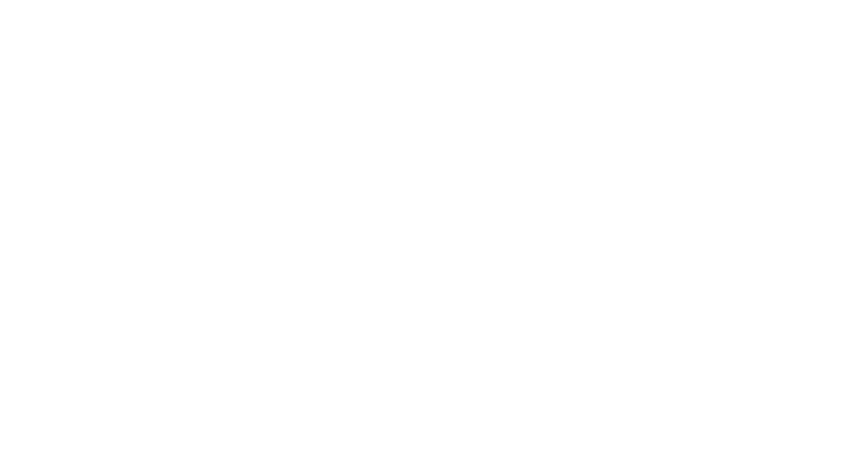

In [83]:
import geoplot
import geoplot.crs as gcrs
from celluloid import Camera
from IPython.display import HTML
contiguous_usa = gpd.read_file(geoplot.datasets.get_path('contiguous_usa'))
ax3 = geoplot.webmap(contiguous_usa,projection=gcrs.WebMercator(),figsize=(15,10))
fig3 = ax3.get_figure()
camera = Camera(fig3)
for day in day_list[::5]:
    print(day)
    geoplot.webmap(contiguous_usa,projection=gcrs.WebMercator(),ax=ax3)

    test_geo = gpd.GeoDataFrame(final_geo_df[final_geo_df['date']==day])
    geoplot.choropleth(
    test_geo, hue='cases', 
    cmap='Reds', ax = ax3, edgecolor=None,scheme = scheme,legend=True, legend_kwargs={'bbox_to_anchor':(.9,.2)}
 )
    ax3.text(0.5,1,'Total Covid Cases by Country: {}'.format(day),fontsize=20,horizontalalignment='center',transform = ax3.transAxes)
#     ax3.axis('off')
    
    camera.snap()
animation = camera.animate(interval=500)
# animation.save('/data/refinance-thought-leadership/output_data/500ms_refi_index_2019_map.mp4')
HTML(animation.to_html5_video())


In [89]:
NY = results_df[results_df['state']=='New York City'].reset_index(drop=True)
NY.head()

,data_as_of,start_week,end_week,group,state,indicator,covid_deaths,total_deaths,percent_of_expected_deaths,pneumonia_deaths,pneumonia_and_covid_deaths,influenza_deaths,pneumonia_influenza_and_covid,footnote
0,2020-05-08,2020-02-01,2020-02-01,By week,New York City,Week-ending,0,1168.0,1.02,95.0,0.0,19.0,114.0,NaN
1,2020-05-08,2020-02-08,2020-02-08,By week,New York City,Week-ending,0,1169.0,0.97,95.0,0.0,18.0,113.0,NaN
2,2020-05-08,2020-02-15,2020-02-15,By week,New York City,Week-ending,0,1130.0,0.99,86.0,0.0,13.0,99.0,NaN
3,2020-05-08,2020-02-22,2020-02-22,By week,New York City,Week-ending,0,1092.0,1.01,75.0,0.0,NaN,84.0,One or more data cells have counts between 1–9...
4,2020-05-08,2020-02-29,2020-02-29,By week,New York City,Week-ending,0,1105.0,1.01,83.0,0.0,NaN,89.0,One or more data cells have counts between 1–9...


In [97]:
NY['start_week'].dt.strftime('%Y-%m-%d')

0     2020-02-01
1     2020-02-08
2     2020-02-15
3     2020-02-22
4     2020-02-29
5     2020-03-07
6     2020-03-14
7     2020-03-21
8     2020-03-28
9     2020-04-04
10    2020-04-11
11    2020-04-18
12    2020-04-25
13    2020-05-02
Name: start_week, dtype: object

/home/jaalhashash/miniconda/envs/jawsem_env/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(left, right)


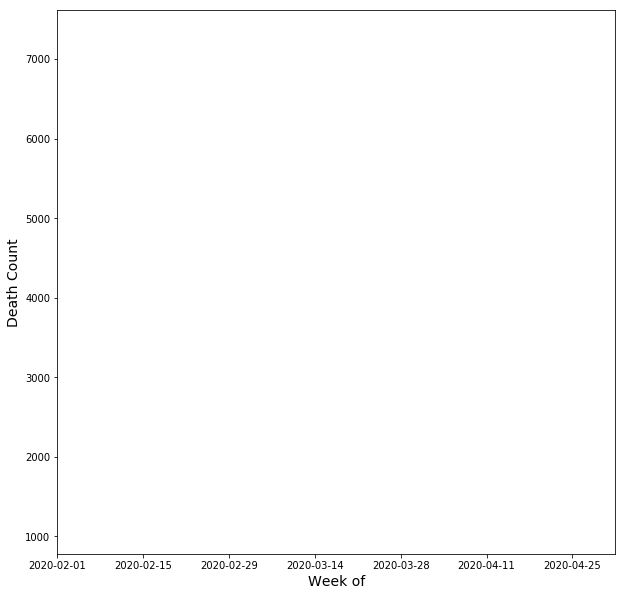

In [135]:
fig,ax = plt.subplots(figsize=(10,10))
camera = Camera(fig)
for i in range(NY.shape[0]):
    NY.iloc[0:i+1]['total_deaths'].plot(ax=ax,color='dodgerblue')
    ax.set_xticklabels(NY['start_week'].dt.strftime('%Y-%m-%d').iloc[::2])
    ax.text(0.5,1.05,'Death Count in NYC: Week of {}: {:.0f}'.format(NY['start_week'].dt.strftime('%Y-%m-%d').iloc[i],NY['total_deaths'].iloc[i]),fontsize=20,horizontalalignment='center',transform = ax.transAxes)
    ax.set_ylabel('Death Count',fontsize=14)
    ax.set_xlabel("Week of",fontsize=14)
    ax.text(1,-.1,'Data Source: https://data.cdc.gov/NCHS/Provisional-COVID-19-Death-Counts-by-Week-Ending-D/r8kw-7aab',fontsize=10,horizontalalignment='right',fontstyle='italic', bbox=dict(facecolor='dodgerblue',alpha=0.5),transform = ax.transAxes)
    camera.snap()
    
animation = camera.animate(interval=500)
animation.save('weekly_deaths_nyc.mp4')

HTML(animation.to_html5_video())


,data_as_of,start_week,end_week,group,state,indicator,covid_deaths,total_deaths,percent_of_expected_deaths,pneumonia_deaths,pneumonia_and_covid_deaths,influenza_deaths,pneumonia_influenza_and_covid,footnote
0,2020-05-08,2020-02-01,2020-02-01,By week,United States,Week-ending,0,57444.0,0.97,3700.0,0.0,471.0,4171.0,NaN
1,2020-05-08,2020-02-08,2020-02-08,By week,United States,Week-ending,1,57766.0,0.97,3686.0,0.0,499.0,4186.0,NaN
2,2020-05-08,2020-02-15,2020-02-15,By week,United States,Week-ending,0,57077.0,0.97,3710.0,0.0,521.0,4231.0,NaN
3,2020-05-08,2020-02-22,2020-02-22,By week,United States,Week-ending,1,57041.0,0.98,3573.0,0.0,541.0,4115.0,NaN
4,2020-05-08,2020-02-29,2020-02-29,By week,United States,Week-ending,7,57252.0,0.99,3663.0,5.0,623.0,4288.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,2020-05-08,2020-04-04,2020-04-04,By week,Puerto Rico,Week-ending,18,430.0,0.78,68.0,NaN,0.0,77.0,One or more data cells have counts between 1–9...
752,2020-05-08,2020-04-11,2020-04-11,By week,Puerto Rico,Week-ending,19,422.0,0.79,62.0,NaN,0.0,72.0,One or more data cells have counts between 1–9...
753,2020-05-08,2020-04-18,2020-04-18,By week,Puerto Rico,Week-ending,15,336.0,0.64,44.0,NaN,NaN,53.0,One or more data cells have counts between 1–9...
754,2020-05-08,2020-04-25,2020-04-25,By week,Puerto Rico,Week-ending,12,208.0,0.38,25.0,NaN,NaN,33.0,One or more data cells have counts between 1–9...
